# Particle Tracker Demo
This file serves to show off a hacked together version of a particle tracker system I would like to build. The applications of this tracker would be to characterize the speed of particles, their shape, the tracks that they pursue and the particle fluxed of the Hyphae that they travel in.

In [92]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import os
import json
from amftrack.util.sys import storage_path
from amftrack.util.sys import temp_path
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
import pandas as pd
from PIL import Image
from scipy import signal
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray


plate_name = '20221109_Plate462_04'

img_seq = glob.glob(storage_path + '\\' + plate_name + '\\*')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing
This file will use the TIFF format from the transfer setup. These videos can sometimes have a bit of vibration in them, and they can be grainy. Some preprocessing options should be available to blur and stabilize the videos.

In [93]:
# for img_name in img_seq:
#     img = cv.imread(img_name)
#     img = cv.GaussianBlur(img, (5,5), 0)
#     cv.imwrite(temp_path + '\\' + img_name[-9:-5]+'.tiff', img)

img = cv.imread(img_seq[-1], cv.IMREAD_GRAYSCALE)
Y_RES, X_RES = np.shape(img)

## Hypha Detection
For the purposes of this project, it might be useful to be able to filter out the non-hypha data. These functions then serve to create a binary map between hypha and non-hypha pixels.

In [94]:
# histr1 = cv2.calcHist([img],[0],None,[256],[0,256])
# histr2 = cv2.calcHist([imgB],[0],None,[256],[0,256])

# fig, ax = plt.subplots(1,2)
# ax[0].plot(histr1[0:30])
# ax[1].plot(histr2[0:30])

# find_thresh_fluo(imgB)

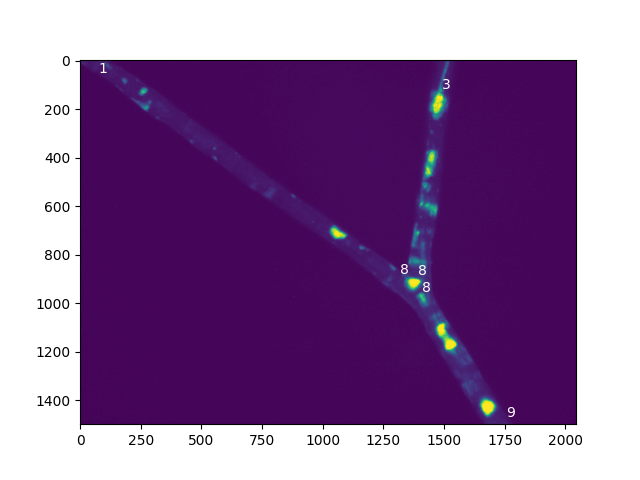

In [95]:
segmented, nx_graph_pruned, pos = segment_fluo(img, thresh=0.5e-9)

fig, ax = plt.subplots()

weight = 0.05
for edge in list(nx_graph_pruned.edges):
    ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
    ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")

edges = list(nx_graph_pruned.edges)
edge_oriented = []
for edge in edges:
    if pos[edge[0]][0]>pos[edge[1]][0]:
        edge_oriented.append(edge)
    else:
        edge_oriented.append((edge[1],edge[0]))
edges = edge_oriented

edge_oriented

np.linalg.norm(pos[edge[0]]-pos[edge[1]])

ax.imshow(img)

## Blob detection
Using the blob detector from OpenCV, we create a JSON file that will record prominent features on a sequence of frames with regular spacing in between. 

In [96]:
data = {
    'res' :
        {
            'RES_X' : X_RES,
            'RES_Y' : Y_RES
        }
    ,
    'frame' : {}
}

for i in range(0, len(img_seq), 100):
    data['frame'][i] = []
    frame = Image.open(img_seq[i])
    frameImg = np.array(frame)
    imgB = cv2.GaussianBlur(frameImg, (5,5), 0)
    blobs_log = blob_log(imgB, max_sigma=30, num_sigma=3, threshold=.07)
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
    # data['frame'][i] = [ {'x': blobs_log[k,0], 'y': blobs_log[k,1], 'r': blobs_log[k,2]} for k in range(len(blobs_log))]
    for k in range(len(blobs_log)):
        if segmented[int(blobs_log[k,0])][int(blobs_log[k,1])]:
            data['frame'][i].append({'x': blobs_log[k,0], 'y': blobs_log[k,1], 'r': blobs_log[k,2]})
    with open('json_data.json', 'w') as outfile:
        json.dump(data, outfile)


## Treatment of certain frames
The preprocessing described above does not have to be done to every frame. We trust Blender to be able to track particles through a certain amount of frames. As such, we only have to detect blobs and initiate tracking in a few frames of the video.

## Blender
This is where the magic happens. We are running Blender in the background in order to use its particle tracking system. This means that we need to open it in the background, and let it run a script. Then Blender will save the tracking data in a file format that was chosen for this.